# Analysis of probe

In [44]:
import numpy as np
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
import scipy.special
import scipy.optimize

## Read from file

In [2]:
GunXPosition = np.empty((80, 1))
GunYPosition = np.empty((80, 1))
GunZPosition = np.empty((80, 1))
PE = np.empty((80, 2, 1000))

for run_number in tqdm(range(80)):
    with open(f"./run{run_number}/RunConditions.json", "r") as run_conditions_json:
        run_condition_loaded = json.load(run_conditions_json)
        GunXPosition[run_number] = run_condition_loaded["GunXPosition/cm"]
        GunYPosition[run_number] = run_condition_loaded["GunYPosition/cm"]
        GunZPosition[run_number] = run_condition_loaded["GunZPosition/cm"]
    
    for SiPMNb in range(2):
        with open(f"./run{run_number}/PEs of SiPM/SiPM_{SiPMNb}.csv", "r") as PEFile:
            PE[run_number][SiPMNb] = np.loadtxt(PEFile, comments='#', delimiter=',', dtype=np.int8, usecols=0)

100%|██████████| 80/80 [00:00<00:00, 315.52it/s]


## Single distribution validation

It is postulated that the distribution of PEs are poisson-like or binomial. Here, the two distributions are the same.

0.000665825


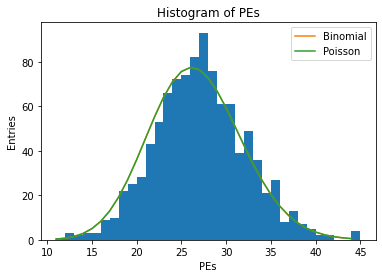

In [65]:
test_PE_Data = PE[20][0]

plt.hist(test_PE_Data, bins=int(test_PE_Data.max() - test_PE_Data.min()))

def binomial_prob(single_prob, n, result):
    return scipy.special.comb(n, result)*single_prob**result*(1-single_prob)**(n-result)

def poisson_prob(expectation, result):
    return expectation**result/scipy.special.factorial(result)*np.exp(-expectation)

single_prob = test_PE_Data.mean()/40000
print(single_prob)
sample = np.arange(int(test_PE_Data.min()), int(test_PE_Data.max()), 1)

theory_binomial = binomial_prob(single_prob, 40000, sample)*1000
theory_poisson = poisson_prob(single_prob*40000, sample)*1000

plt.plot(sample, theory_binomial, label="Binomial")
plt.plot(sample, theory_poisson, label="Poisson")
plt.xlabel("PEs")
plt.ylabel("Entries")
plt.title("Histogram of PEs")
plt.legend()
plt.savefig('test_PE_distribution.png', dpi=600, bbox_inches='tight')

Two approaches can be used to determine the probability of a single photon coming into the SiPM. One is to use the mean value; the other is to define $\chi^2$ and minimizing that.
$$\chi^2 = \sum_{i=1}^{k} \frac{(f_i - np_i)^2}{np_i}$$

In [68]:
def chi2(single_prob, *args):
    experiment_data = args[0]
    experiment_times = args[1]
    experiment_hist, _ = np.histogram(experiment_data, bins=int(experiment_data.max())-int(experiment_data.min()))
    sample = np.arange(int(experiment_data.min()), int(experiment_data.max()))
    prob = binomial_prob(single_prob, 40000, sample)
    return np.sum((experiment_hist-experiment_times*prob)**2/(experiment_times*prob))

new_single_prob = scipy.optimize.minimize(chi2, single_prob, args=(test_PE_Data, 1000), bounds=((single_prob/2, single_prob*2),)).x
print(new_single_prob)

[0.00066976]
